# Over Current Relay (OC relay)

Pandapower supports running protection scenarios using Definite Time Over Current Relay (DTOC), Inverse Definite Minimum Time (IDMT) and Inverse Definite Time Minimum over current Relay, which is a combination of DTOC and IDMT (IDTOC) in radial and meshed networks. It supports the automated time grading plan based on grid searches and manual time grading.

### Example Network
Here is a little example of creating the over-current protection scenario. First, we create a network with 7 buses and 5 switches. The switch is type defined as 'CB_DTOC' for running protection scenarios using DTOC relay, 'CB_IDMT' for using IDMT relay and 'CB_IDTOC' for using IDTOC relay.


In [1]:
from pandapower.create import (
    create_empty_network,
    create_buses,
    create_ext_grid,
    create_lines,
    create_loads,
    create_switches
)

In [2]:
def oc_relay_net():
    # create an empty network
    net = create_empty_network()
    
    #create buses
    create_buses(net, nr_buses=7, vn_kv=20, index=[0,1,2,3,4,5,6], name=None, type="n",
                    geodata=[(0,0), (0, -1), (-2, -2), (-2, -4), (2, -2), (2, -3), (2, -4)])

    # create external grids
    create_ext_grid(net, 0, vm_pu=1.0, va_degree=0, s_sc_max_mva=100, s_sc_min_mva=50, rx_max=0.1, rx_min=0.1)
    
    create_lines(net, from_buses=[0,1,2,1,4,5], to_buses=[1,2,3,4,5,6], length_km=[2,5,4,4,0.5,0.5],std_type="NAYY 4x50 SE",
                 name=None, index=[0,1,2,3,4,5], df=1., parallel=1)

    net.line["endtemp_degree"] = 250
    
    # Define switches
    create_switches(net, buses =  [0,1,1,2,4,5], elements =
                       [0,1,3,2,4,5], et = 'l', type ="CB_DTOC")
    #define load
    create_loads(net, buses=[3,6], p_mw=[5,2], q_mvar=[1,1], const_z_percent=0, const_i_percent=0, sn_mva=None,
                     name=None, scaling=1., index=[0,1])

    return net

##  OC Relay Class

Users can create over-current relays in circuits by calling the OCRelay class on switches within a pandapower network. 

INPUT:

        **net** (attrdict) - pandapower net

        **switch_index** (int) - index of the switch that the relay acts upon

        **oc_relay_type** (str) - string specifying the type of over-current protection. Must be either "DTOC", "IDMT",
        or "IDTOC".

        **time_settings** (list of DataFrame) - If given as a list, the time grading will be calculated based on
        topological grid search, and manual tripping time can be provided as a dataframe by the respective column names.

                For DTOC:
                time_settings =[t>>, t>, t_diff] or Dataframe columns as 'switch_id', 't_gg', 't_g'

                - t>> (t_gg): instantaneous tripping time in seconds
                - t> (t_g):  primary backup tripping time in seconds,
                - t_diff: time grading delay difference in seconds


                For IDMT:
                time_settings =[tms, t_grade] or Dataframe columns as 'switch_id', 'tms', 't_grade'

                - tms: time multiplier settings in seconds
                - t_grade:  time grading delay difference in seconds

                For IDTOC:
                time_settings =[t>>, t>, t_diff, tms,t_grade] or Dataframe columns as 'switch_id', 't_gg', 't_g','tms', 't_grade'

                - t>> (t_gg): instantaneous tripping time in seconds
                - t> (t_g):  primary backup tripping time in seconds,
                - t_diff: time grading delay difference in seconds
                - tms: time multiplier settings in seconds
                - t_grade:  time grading delay difference in seconds

        **overload_factor** - (float, 1.25)- Allowable overloading on the line used to calculate the pick-up current

        **ct_current_factor** -(float, 1.2) - Current multiplication factor to calculate the pick-up current

        **safety_factor** -(float, 1) - Safety limit for the instantaneous pick-up current

        **inverse_overload_factor** -(float, 1.2)- Allowable inverse overloading to define the pick-up current in IDMT
        relay

        **pickup_current_manual** - (DataFrame, None) - User-defined relay trip currents can be given as a dataframe.

                DTOC: Dataframe with columns as 'switch_id', 'I_gg', 'I_g'

                IDMT: Dataframe with columns as 'switch_id', 'I_s'

                IDTOC: Dataframe with columns as 'switch_id', 'I_gg', 'I_g', 'I_s'

        **in_service** (bool, True) - specify whether relay is in service

        **overwrite** (bool, True) - specify whether this oc relay should overwrite existing protection devices acting
        on the switch

        **sc_fraction** (float, 0.95) - Maximum possible extent to which the short circuit can be created on the line

        **curve_type** (str, 'standard_inverse') - specify the type of curve used in IDMT and IDTOC.

            Curve type can be:
                 - 'standard_inverse'
                 - 'very_inverse',
                 - 'extremely_inverse',
                 - 'long_inverse'
                 
## DTOC Relay

We will now create DTOC relays at each switch in the network. 

In [3]:
net = oc_relay_net()
from pandapower.protection.protection_devices.ocrelay import OCRelay

for k in range(6):
    OCRelay(net, switch_index=k, oc_relay_type='DTOC', time_settings=[0.07, 0.5, 0.3])

Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers


To run a fault scenario on a line, create a short circuit at the desired location by calling create_sc_bus(). Then, call calc_sc() to perform the short circuit calculation. For line faults, the bus argument of calc_sc() should be the highest bus index because create_sc_bus() inserts a virtual bus at the desired location on the line and appends a bus index to the network. When calling calc_sc(), make sure to specify branch_results=True. 

To see how the over-current relays respond, call calculate_protection_times(). For faults, the scenario should be 'sc'. 

In [4]:
from pandapower.protection.utility_functions import create_sc_bus
import pandapower.shortcircuit as sc
from pandapower.protection.run_protection import calculate_protection_times

# calculate the short circuit
net_sc = create_sc_bus(net, sc_line_id=4, sc_fraction=0.5)
sc.calc_sc(net_sc, bus=max(net_sc.bus.index), branch_results=True)

# calculate the protection times
protection_results = calculate_protection_times(net_sc, scenario='sc')

# show protection_results
protection_results

Branch results are in beta mode and might not always be reliable, especially for transformers


,switch_id,protection_type,trip_melt,activation_parameter,activation_parameter_value,trip_melt_time_s
0,0,OCRelay,True,i_ka,1.919548,1.40
1,1,OCRelay,False,i_ka,0.000000,inf
2,2,OCRelay,True,i_ka,1.919548,1.10
3,3,OCRelay,False,i_ka,0.000000,inf
4,4,OCRelay,True,i_ka,1.919548,0.07
5,5,OCRelay,False,i_ka,0.000000,inf


### Show tripped grid

Shows tripped switches, short circuit currents, sc location with respective annotations

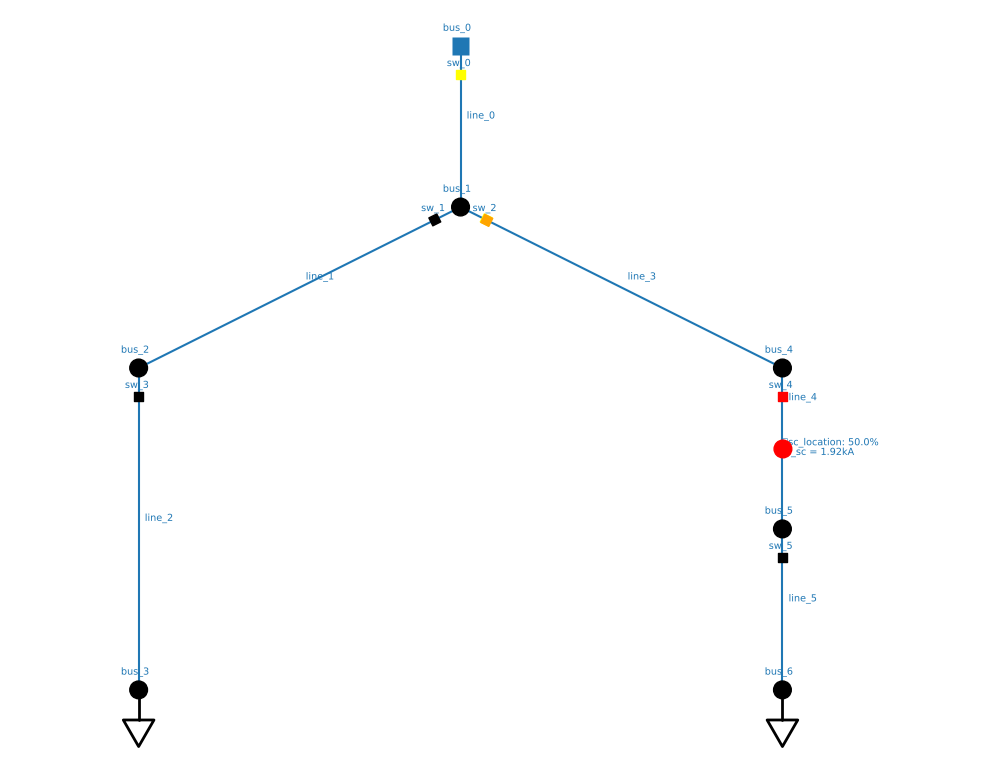

In [5]:
from pandapower.protection.utility_functions import plot_tripped_grid_protection_device
plot_tripped_grid_protection_device(net_sc, protection_results, sc_bus=max(net_sc.bus.index), sc_location=0.5)


### Create I-t Plot
To view the time-current characteristic curve of an oc relay, call its plot_protection_characteristic() method.

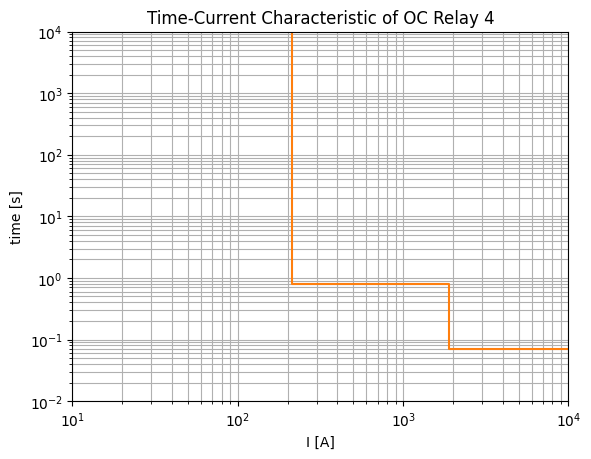

In [6]:
net.protection.object.at[4].plot_protection_characteristic(net=net, xmin=10, xmax=10000, ymin=0.01, ymax=10000)

##  IDMT Relay 

IDMT largely follow the same procedure as DTOC, with the main difference being the time_settings parameters. The example below will show the same steps as in DTOC.

In [7]:
# Change the switch type in the network

net=oc_relay_net()
net.switch.type='CB_IDMT'

# create IDMT OC Relays
for k in range(6):
    OCRelay(net, switch_index=k, oc_relay_type='IDMT', time_settings=[1, 0.5])
    
# create short circuit
net_sc = create_sc_bus(net, sc_line_id=4, sc_fraction=0.5)
sc.calc_sc(net_sc, bus=max(net_sc.bus.index), branch_results=True)

# find protection results
protection_results = calculate_protection_times(net_sc, scenario='sc')

# show protection_results
protection_results

Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers


,switch_id,protection_type,trip_melt,activation_parameter,activation_parameter_value,trip_melt_time_s
0,0,OCRelay,True,i_ka,1.919548,4.821101
1,1,OCRelay,False,i_ka,0.000000,inf
2,2,OCRelay,True,i_ka,1.919548,4.321101
3,3,OCRelay,False,i_ka,0.000000,inf
4,4,OCRelay,True,i_ka,1.919548,3.821101
5,5,OCRelay,False,i_ka,0.000000,inf


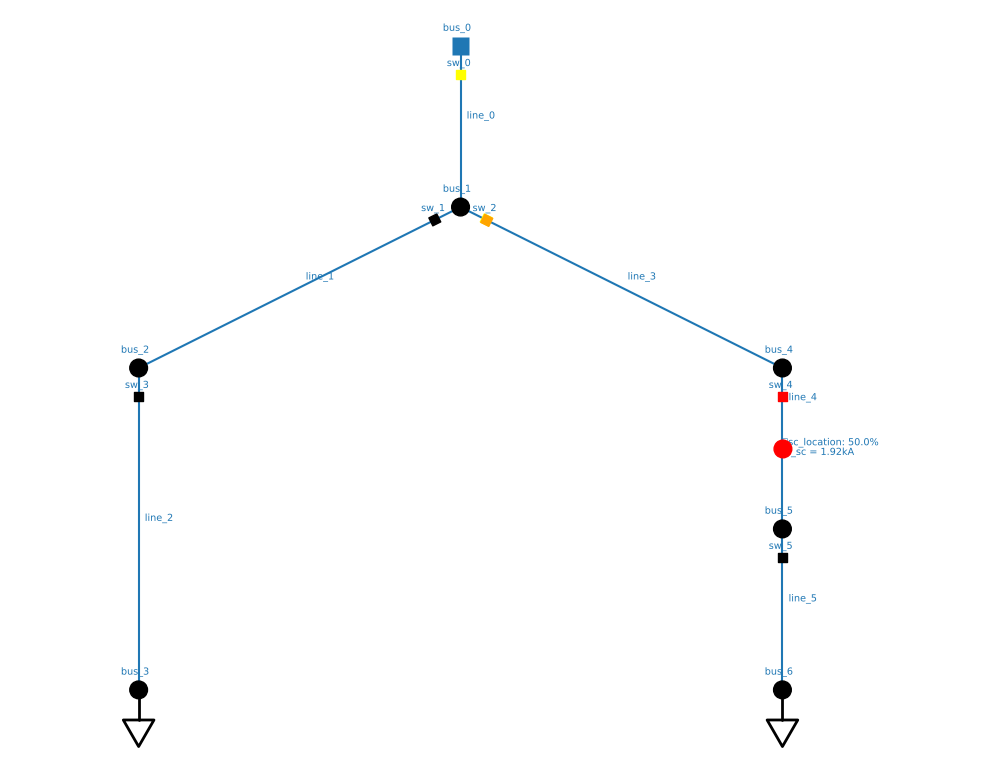

In [8]:
# show tripped grid
plot_tripped_grid_protection_device(net_sc, protection_results, sc_bus=max(net_sc.bus.index), sc_location=0.5)

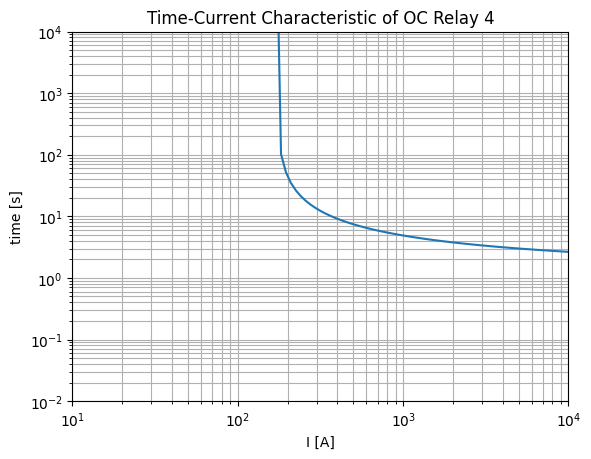

In [9]:
# show time-current characteristic of oc relay at switch 4
net.protection.object.at[4].plot_protection_characteristic(net=net, xmin=10, xmax=10000, ymin=0.01, ymax=10000)

All the additional features and plotting functions are possible for IDMT relay (similar to DTOC)

##  IDTOC Relay 

The procedure for IDTOC relays is very similar to DTOC and IDMT. Make sure to specify the time_settings appropriately. 

In [10]:
# Change the switch type in the network
net=oc_relay_net()
net.switch.type='CB_IDTOC'

# create IDTOC relays in the network
for k in range(6):
    OCRelay(net, switch_index=k, oc_relay_type='IDTOC', time_settings=[0.07, 0.5, 0.3, 1, 0.5])

# create short circuit
net_sc = create_sc_bus(net, sc_line_id=4, sc_fraction=0.5)
sc.calc_sc(net_sc, bus=max(net_sc.bus.index), branch_results=True)
protection_results = calculate_protection_times(net_sc, scenario='sc')
                                                
# find protection results
protection_results = calculate_protection_times(net_sc, scenario='sc')

# show protection_results
protection_results

Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers
Branch results are in beta mode and might not always be reliable, especially for transformers


,switch_id,protection_type,trip_melt,activation_parameter,activation_parameter_value,trip_melt_time_s
0,0,OCRelay,True,i_ka,1.919548,1.40
1,1,OCRelay,False,i_ka,0.000000,inf
2,2,OCRelay,True,i_ka,1.919548,1.10
3,3,OCRelay,False,i_ka,0.000000,inf
4,4,OCRelay,True,i_ka,1.919548,0.07
5,5,OCRelay,False,i_ka,0.000000,inf


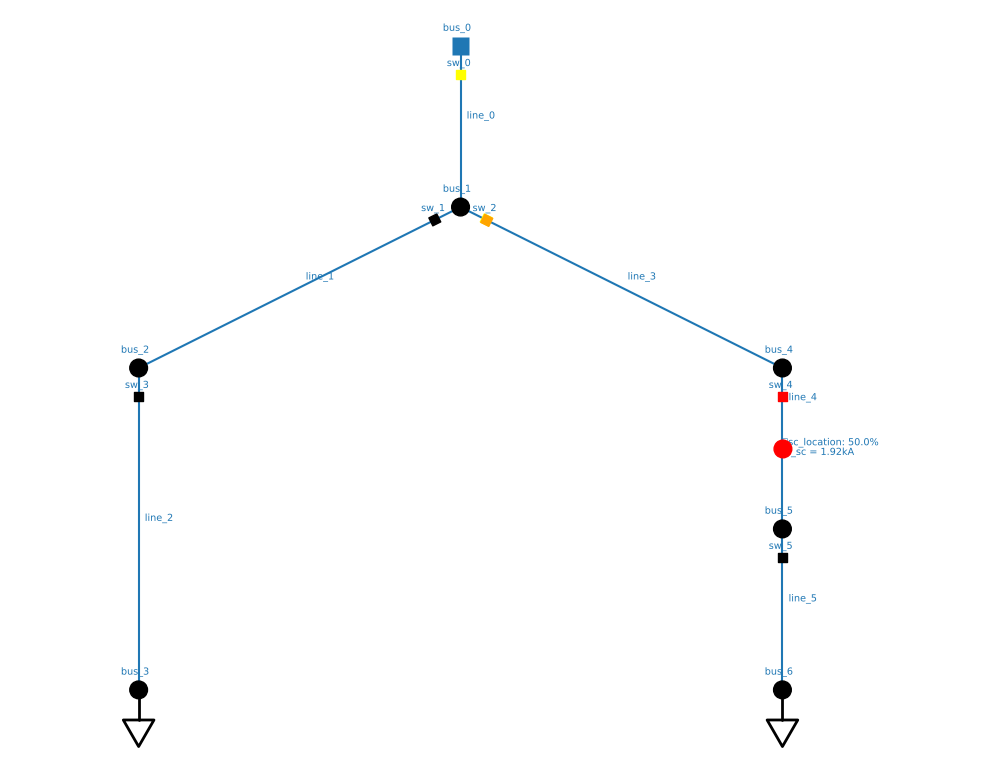

In [11]:
# show tripped grid
plot_tripped_grid_protection_device(net_sc, protection_results, sc_bus=max(net_sc.bus.index), sc_location=0.5)

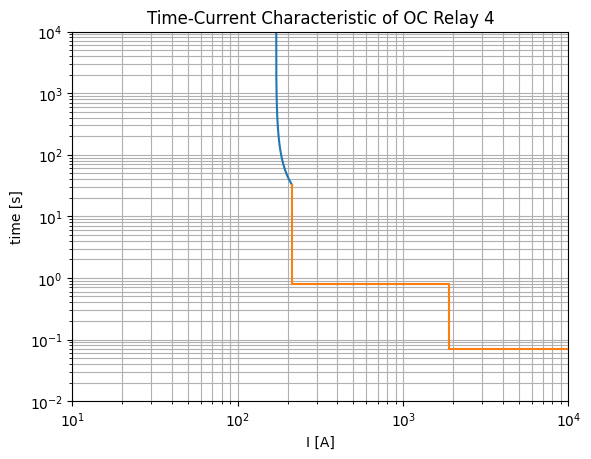

In [12]:
# show time-current characteristic of oc relay at switch 4
net.protection.object.at[4].plot_protection_characteristic(net=net, xmin=10, xmax=10000, ymin=0.01, ymax=10000)

##  All the additional features which are previously described will also function for IDTOC relay